# **Deep learning for dynamic network analysis (DLDNA) - Final project** <br>
**Dolphins:** R. ARNAUD M. DELPLANQUE A. KARILA-COHEN A. RAMPOLDI <br> **Dataset:** Comprehensive soil classification dataset: https://www.kaggle.com/datasets/ai4a-lab/comprehensive-soil-classification-datasets/code

_______________

# Notebook 0 — CNN Architecture and Feature-Based Soil Classification

> This notebook focuses on convolutional neural network (CNN)–based soil classification using the preprocessed image dataset.  <br>
> The objectives are: <br>
> - To design a baseline CNN architecture trained from scratch, <br>
> - To analyze learned visual features relevant for soil classification, <br> 
> - To optimize model performance through systematic hyperparameter tuning. <br>

### Methodology
The CNN processes RGB soil images resized (with cropping) to 256x256 pixels. Feature extraction is performed implicitly through stacked convolutional layers with ReLU activation and max-pooling. The classifier head consists of fully connected layers followed by a softmax output for 7 soil classes: ```Alluvial_Soil, Arid_Soil,Black_Soil, Laterite_Soil, Mountain_Soil, Red_Soil, Yellow_Soil.```

A grid search strategy is then used to optimize key hyperparameters, including:
- Learning rate,
- Weight decay,
- Dropout.

Model selection is based on validation accuracy and stability during training.

### Output
The best-performing CNN model obtained in this notebook is later reused (saved as ```best_model```):
- As part for performance comparison,
- As an evaluation backbone for GAN-augmented datasets.

____________________

### **Preliminnary tasks**

**Import of the libraries**

> **Imports and Environment Setup**
> 
> This section imports all required libraries for data preprocessing, model training, and evaluation.  
> Warnings are suppressed for cleaner outputs. PyTorch is used for model implementation and optimization, while OpenCV and PIL handle image processing. Scikit-learn provides dataset splitting and evaluation metrics, and Matplotlib is used for visualization.

In [3]:
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings to keep notebook clean

import random
import numpy as np
import matplotlib.pyplot as plt
import math
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

import sys
import pandas as pd
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torch.utils.data import Dataset

**Project paths and Utility Loading**

The project root directory is defined using ```pathlib``` to ensure reproducibility across environments. 

Custom utility modules ```utils.py``` and ```visualization.py``` are imported from the `src/` directory. These utilities handle:
- Loading global parameters from the txt file ```/txt/parameters.txt```,
- Image loader and preprocesser,
- Visualization of soil image grids for qualitative inspection.


In [4]:
PROJECT_ROOT = Path.cwd().parent.resolve()
DATA_DIR= PROJECT_ROOT / "data"
PARAM_FILE = PROJECT_ROOT / "txt" / "parameters.txt"
UTILS_DIR = PROJECT_ROOT / "src"

# utils.py and visualization.py functions
sys.path.append(str(PROJECT_ROOT / "src"))
from utils import load_parameters, load_and_pre_process_images, inspect_architecture, verify_class_distribution
from visualization import show_soil_grid

**Choose the good torch device**

In [5]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'xpu' if hasattr(torch, "xpu") and torch.xpu.is_available() else 'cpu'
print(f"Params loaded. Device: {DEVICE}")

Params loaded. Device: cpu


**General parameters**

### Configuration and Parameter Loading

All training and preprocessing parameters are externalized and loaded from a dedicated text configuration file located in the `txt/` directory. This approach ensures reproducibility, consistency across notebooks, and easy experimentation without modifying the source code.

The configuration file defines the following parameters:

- **Dataset split ratios**:
  - `TRAIN_RATIO = 0.7`
  - `VAL_RATIO = 0.1`
  - `TEST_RATIO = 0.2` 

- **Training parameters**:
  - `BATCH_SIZE = 64`
  - `EPOCHS = 100`
  - `SEED = 42`  
  The batch size and number of epochs define the training loop + a fixed random seed guarantees reproducible results.

- **Optimization parameters**:
  - `LEARNING_RATE = 0.01`
  - `lr = 0.0001`
  - `weight_decay = 0.0001`
  - `dropout = 0.3`  
  These parameters control the learning dynamics, regularization strength, and overfitting mitigation(They come from the execution of the *Grid search* at the end of this notebook).

- **Input configuration**:
  - `IMAGE_SIZE = 256`  
  All images are resized to a uniform size of 256×256 pixels to ensure compatibility with the architectures without losing too much info.

- **Classification labels**:
  - `SOIL_TYPES = Alluvial_Soil, Arid_Soil, Black_Soil, Laterite_Soil, Mountain_Soil, Red_Soil, Yellow_Soil`  
  This list defines the 7 target classes and is used for dataset loading, label encoding, and evaluation.

By centralizing these parameters in a configuration file, the experimental setup remains transparent, modular, and easily adjustable for future extensions or sensitivity analyses.


In [6]:
# Load parameters from external file
params = load_parameters(PARAM_FILE)
globals().update(params)
soil_types = [s.strip() for s in params["SOIL_TYPES"].split(",")]

# Use parameters for seed and device
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


Loaded parameters:
  TRAIN_RATIO = 0.7
  VAL_RATIO = 0.1
  TEST_RATIO = 0.2
  BATCH_SIZE = 64
  EPOCHS = 100
  LEARNING_RATE = 0.01
  SEED = 42
  IMAGE_SIZE = 256
  lr = 0.0001
  dropout = 0.3
  weight_decay = 0.0001
  SOIL_TYPES = Alluvial_Soil,Arid_Soil,Black_Soil,Laterite_Soil,Mountain_Soil,Red_Soil,Yellow_Soil


**Load the dataset**

In [7]:
# Load and preprocess images
images_dict = {}  # Dictionary to hold images per soil type
for soil in soil_types:
    folder = DATA_DIR / "Orignal-Dataset" / soil
    images = load_and_pre_process_images(
        folder_path=folder,
        target_size=IMAGE_SIZE  # <--- Indispensable
    )
    images_dict[soil] = images
    print(f"{soil}: {len(images)} images loaded and preprocessed")

Alluvial_Soil: 52 images loaded and preprocessed
Arid_Soil: 284 images loaded and preprocessed
Black_Soil: 255 images loaded and preprocessed
Laterite_Soil: 219 images loaded and preprocessed
Mountain_Soil: 201 images loaded and preprocessed
Red_Soil: 109 images loaded and preprocessed
Yellow_Soil: 69 images loaded and preprocessed


**Display the first pictures of each type of soil**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0590332..4.995021].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0451112..2.1259637].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9677533..4.3660645].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.283933..3.2710366].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9346344..2.9974468].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.751741..3.7859335].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.4708412..

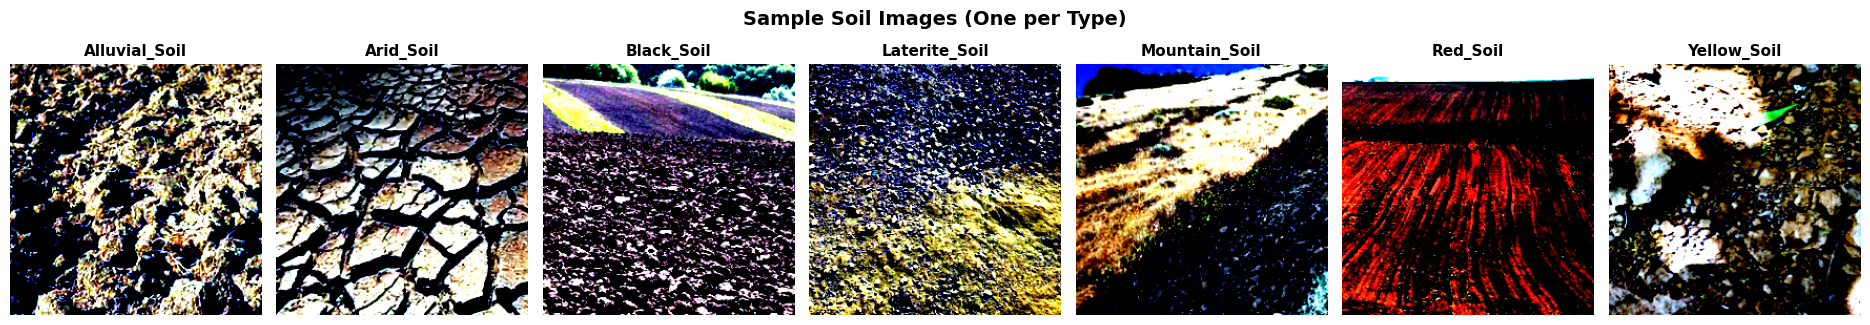

In [8]:
show_soil_grid(images_dict, n_per_type=5)

**Create Results folder to store the results**

### Results Directory Structure

A dedicated directory hierarchy is created to store outputs from each experiment in a structured and reproducible manner.  
A common root folder is used for all results, with separate subdirectories for each model family (CNN, GAN, StarGAN, and attention-based models).

This organization facilitates result tracking, comparison, and post-processing across different architectures and training strategies.


In [9]:
# Create results folder structure
from pathlib import Path

results_root = (Path('..') / 'results').resolve()
subfolders = ['CNN', 'GAN', 'StarGAN', 'Attention']

results_root.mkdir(parents=True, exist_ok=True)
for name in subfolders:
    (results_root / name).mkdir(parents=True, exist_ok=True)

print(f"Created/verified results root: {results_root}")
for name in subfolders:
    print(f" - {results_root / name}")

Created/verified results root: C:\Users\romai\OneDrive\Documents\_ENTPE\Formation\Data science\DLDNA\DLDNA - Project\results
 - C:\Users\romai\OneDrive\Documents\_ENTPE\Formation\Data science\DLDNA\DLDNA - Project\results\CNN
 - C:\Users\romai\OneDrive\Documents\_ENTPE\Formation\Data science\DLDNA\DLDNA - Project\results\GAN
 - C:\Users\romai\OneDrive\Documents\_ENTPE\Formation\Data science\DLDNA\DLDNA - Project\results\StarGAN
 - C:\Users\romai\OneDrive\Documents\_ENTPE\Formation\Data science\DLDNA\DLDNA - Project\results\Attention


### CNN Architecture Definition

The CNN architecture ```SimpleCNN``` is designed to progressively extract hierarchical visual features from soil images.  
It consists of five convolutional blocks, each combining convolution, ```batch normalization```, ```ReLU``` activation, and ```max-pooling```. The number of filters doubles at each stage (32 → 512), to capture better textures.

Spatial dimensions are reduced using the max-pooling. A Global Average Pooling is then applied at the end of the convolutional stack to reduce the feature maps.

The model is composed of:
- A fully connected layer with dropout for regularization,
- A final linear layer mapping to the 7 soil classes.

*This architecture is trained from scratch and serves as the baseline model for comparison with attention-based and GAN-augmented approaches.*


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super().__init__()
        # 1. 32 filtres | Entrée 256x256 -> Sortie 128x128 (après pool)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        # 2. 64 filtres | 128x128 -> 64x64
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # 3. 128 filtres | 64x64 -> 32x32
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # 4. 256 filtres | 32x32 -> 16x16
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        # 5. 512 filtres | 16x16 -> 8x8
        # Pour du 256x256, une 5ème couche permet d'extraire des features très riches
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)

        self.pool = nn.MaxPool2d(2)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # Entrée 512 car conv5 sort 512 canaux
        self.fc1 = nn.Linear(512, 256)
        self.drop = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(256, 7)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))

        # Global Average Pooling : (batch, 512, 8, 8) -> (batch, 512, 1, 1)
        x = self.gap(x)
        x = x.view(x.size(0), -1) 

        x = self.drop(F.relu(self.fc1(x)))
        return self.fc2(x)

**Dataset Splitting**

The dataset is split into training, validation, and test sets using *stratified sampling* to preserve class distribution.  The split is a 70% / 10% / 20% share, with the fixed random seed (defined as above) to ensure reproducibility.


In [11]:
all_images = []
all_labels = []
for soil_type, images in images_dict.items():
    for img, filename in images:
        all_images.append(img)
        all_labels.append(soil_type)

X_temp, X_test, y_temp, y_test = train_test_split(all_images, all_labels, test_size=TEST_RATIO, random_state=SEED, stratify=all_labels)
relative_val_ratio = VAL_RATIO / (TRAIN_RATIO + VAL_RATIO)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=relative_val_ratio, random_state=SEED, stratify=y_temp)

print(f"Dataset split: train ({len(X_train)}), val ({len(X_val)}), test ({len(X_test)})")

Dataset split: train (832), val (119), test (238)


**Custom PyTorch Dataset**

A custom `SoilDataset` class is implemented to interface the soil images with PyTorch. Images are converted to channel-first format (C × H × W) and covnerted to float tensors. Soil type labels are also into integer indices to be compatible with the classification loss. 


In [12]:
class SoilDataset(Dataset):
    def __init__(self, images, labels):
        self.data = images
        self.labels = labels
        unique_labels = sorted(list(set(labels)))
        self.soil_type_to_idx = {soil_type: idx for idx, soil_type in enumerate(unique_labels)}
        self.label_indices = [self.soil_type_to_idx[label] for label in labels]
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):         
        img = self.data[idx]
        img = np.transpose(img, (2, 0, 1))
        img_tensor = torch.FloatTensor(img)
        label = self.label_indices[idx]
        return img_tensor, label

**Dataset Instantiation**

The custom dataset class is instantiated for the training, validation, and test sets.  

In [13]:
train_dataset = SoilDataset(X_train, y_train)
val_dataset = SoilDataset(X_val, y_val)
test_dataset = SoilDataset(X_test, y_test)
print(f"Datasets created - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Datasets created - Train: 832, Val: 119, Test: 238


A data loader is defined for the training and validation set to make learning with shuffled samples.

In [18]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

**Model Initialization and Training Setup**

The CNN model is instantiated and put to the computation device (CPU or GPU or XPU). Training uses the *cross-entropy* loss function for *multi-class classification* and the *Adam optimizer* with **weight decay** to improve generalization.  

In [14]:
model = SimpleCNN().to(DEVICE)  # Create model and move to device

loss_fn = nn.CrossEntropyLoss()  # Binary Cross Entropy loss
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)  # Adam optimizer using weight decay which helps regularization in order to reduce overfitting


### Class Distribution Verification

This function is used to verify the distribution of soil classes across the training, validation, and test datasets.  
It counts the number of samples per class in each split and prints a summary table, ensuring that stratified splitting has been correctly applied and that no class is under- or over-represented in a given subset.

In [19]:
# Verify class distribution across dataset splits
verify_class_distribution(
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    n_classes=len(soil_types)
)

Dataset sizes: Train=832, Val=119, Test=238
Total images: 1189

Per-class distribution:
Class | Train | Val | Test
------|-------|-----|-----
  0   |  37   |  5  |  10
  1   |  199   | 28  |  57
  2   |  178   | 26  |  51
  3   |  153   | 22  |  44
  4   |  141   | 20  |  40
  5   |  76   | 11  |  22
  6   |  48   |  7  |  14


In [ ]:
# Test with our blueprint model
inspect_architecture(model, "SimpleCNN")


=== SimpleCNN Architecture Inspection ===
 2. conv1                | Conv2d          | Params:      896
 3. bn1                  | BatchNorm2d     | Params:       64
 4. conv2                | Conv2d          | Params:    18496
 5. bn2                  | BatchNorm2d     | Params:      128
 6. conv3                | Conv2d          | Params:    73856
 7. bn3                  | BatchNorm2d     | Params:      256
 8. conv4                | Conv2d          | Params:   295168
 9. bn4                  | BatchNorm2d     | Params:      512
10. conv5                | Conv2d          | Params:  1180160
11. bn5                  | BatchNorm2d     | Params:     1024
12. pool                 | MaxPool2d       | Params:        0
13. gap                  | AdaptiveAvgPool2d | Params:        0
14. fc1                  | Linear          | Params:   131328
15. drop                 | Dropout         | Params:        0
16. fc2                  | Linear          | Params:     1799
Total Parameters: 1,703,6

1703687

### Training Loop with Validation

This function trains the CNN with ```EPOCHS=100`` epochs (+ monitoring performance on a validation set).  
For each epoch, it computes training and validation loss and accuracy. The model weights achieving the best validation accuracy are saved as a checkpoint and reloaded at the end. THen the model is used for the next notebooks


In [ ]:
def train_with_validation(model, train_loader, val_loader, optimizer, loss_fn, device, epochs=100):
    """Train the model with validation monitoring and save best checkpoint."""
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    best_val_acc = -1.0
    best_state = None

    for epoch in range(1, epochs + 1):
        # Training phase
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()  # Reset gradients
            preds = model(xb)      # Forward pass
            loss = loss_fn(preds, yb)  # Compute loss
            loss.backward()        # Backward pass
            optimizer.step()       # Update weights using the gradients

            train_loss += loss.item()
            correct += (preds.argmax(dim=1) == yb).sum().item()
            total += yb.size(0)

        train_loss /= len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                val_loss += loss_fn(preds, yb).item()
                correct += (preds.argmax(dim=1) == yb).sum().item()
                total += yb.size(0)

        val_loss /= len(val_loader)
        val_acc = correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        if epoch % 10 == 0 or epoch == 1:
            print(
                f"Epoch {epoch:03d} | "
                f"Train Loss: {train_loss:.4f} Acc: {train_acc:.3f} | "
                f"Val Loss: {val_loss:.4f} Acc: {val_acc:.3f}"
            )
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}

            # Save best model checkpoint to ../models/best_model
            from pathlib import Path
            model_dir = (Path('..') / 'models').resolve()
            model_dir.mkdir(parents=True, exist_ok=True)
            save_path = model_dir / 'best_model'
            torch.save(best_state, save_path)
            print(f"Saved new best model to: {save_path}")

    if best_state is not None:
        model.load_state_dict(best_state)
    
    return model, train_losses, val_losses, train_accs, val_accs

### Model Training

The CNN is trained using the defined training loop herabove

In [ ]:
model, train_losses, val_losses, train_accs, val_accs = train_with_validation(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    device=DEVICE,
    epochs=EPOCHS
)

Epoch 001 | Train Loss: 2.0408 Acc: 0.311 | Val Loss: 42.1841 Acc: 0.235
Saved new best model to: C:\Users\alera\Desktop\ENTPE\Deep Learning\Project\model\best_model
Saved new best model to: C:\Users\alera\Desktop\ENTPE\Deep Learning\Project\model\best_model
Saved new best model to: C:\Users\alera\Desktop\ENTPE\Deep Learning\Project\model\best_model
Saved new best model to: C:\Users\alera\Desktop\ENTPE\Deep Learning\Project\model\best_model
Saved new best model to: C:\Users\alera\Desktop\ENTPE\Deep Learning\Project\model\best_model
Saved new best model to: C:\Users\alera\Desktop\ENTPE\Deep Learning\Project\model\best_model
Epoch 010 | Train Loss: 1.0621 Acc: 0.615 | Val Loss: 1.0338 Acc: 0.605
Saved new best model to: C:\Users\alera\Desktop\ENTPE\Deep Learning\Project\model\best_model
Epoch 020 | Train Loss: 0.8478 Acc: 0.706 | Val Loss: 0.7898 Acc: 0.731
Epoch 030 | Train Loss: 0.6825 Acc: 0.776 | Val Loss: 1.4093 Acc: 0.538
Epoch 040 | Train Loss: 0.6190 Acc: 0.790 | Val Loss: 1.1039

### Model Evaluation on Test Set

This function evaluates the trained model on the held-out test set.  
It computes the average test loss and collects all predicted logits and true labels, which are later used to derive classification metrics and confusion matrices.

In [ ]:
def test_model(model, test_loader, loss_fn, device):
    """
    Perform final testing on the model using the held-out test set.
    """
    model.eval()
    test_loss = 0.0
    all_logits = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            # Forward pass
            logits = model(xb)

            # Accumulate loss
            test_loss += loss_fn(logits, yb).item()

            all_logits.append(logits)
            all_labels.append(yb)

    test_loss /= len(test_loader)
    all_logits = torch.cat(all_logits)
    all_labels = torch.cat(all_labels)

    return test_loss, all_logits, all_labels


### Final Testing

The trained model is evaluated on the test dataset. The test loss, predicted logits, and ground-truth labels are used for final performance analysis.

In [ ]:

test_loss, logits, labels = test_model(
    model=model,
    test_loader=test_loader,
    loss_fn=loss_fn,
    device=DEVICE
)

### Performance Metrics

Final model performance is assessed on the test set using standard multi-class classification metrics.  
Accuracy, precision, recall, and F1-score (weighted by class frequency) are reported to account for dataset imbalance and provide a comprehensive evaluation of the CNN model.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

preds = torch.argmax(logits, dim=1).cpu().numpy()
labels = labels.cpu().numpy()

accuracy  = accuracy_score(labels, preds)
precision = precision_score(labels, preds, average="weighted", zero_division=0)
recall    = recall_score(labels, preds, average="weighted", zero_division=0)
f1        = f1_score(labels, preds, average="weighted", zero_division=0)

print("=" * 50)
print("TEST SET RESULTS - CNN")
print("=" * 50)
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")
print("=" * 50)


TEST SET RESULTS - CNN
Accuracy : 0.7437
Precision: 0.7583
Recall   : 0.7437
F1-score : 0.7298


### Confusion Matrix and Class-wise Analysis

This section vanalyses the model in detail using confusion matrices and per-class accuracy.

It includes:
- **Raw confusion matrix** (counts),
- **Normalized confusion matrix** (percentages per true class),
- **Correct predictions heatmap** (diagonal focus),
- **Per-class accuracy** to highlight classes that are well recognized versus frequently confused.

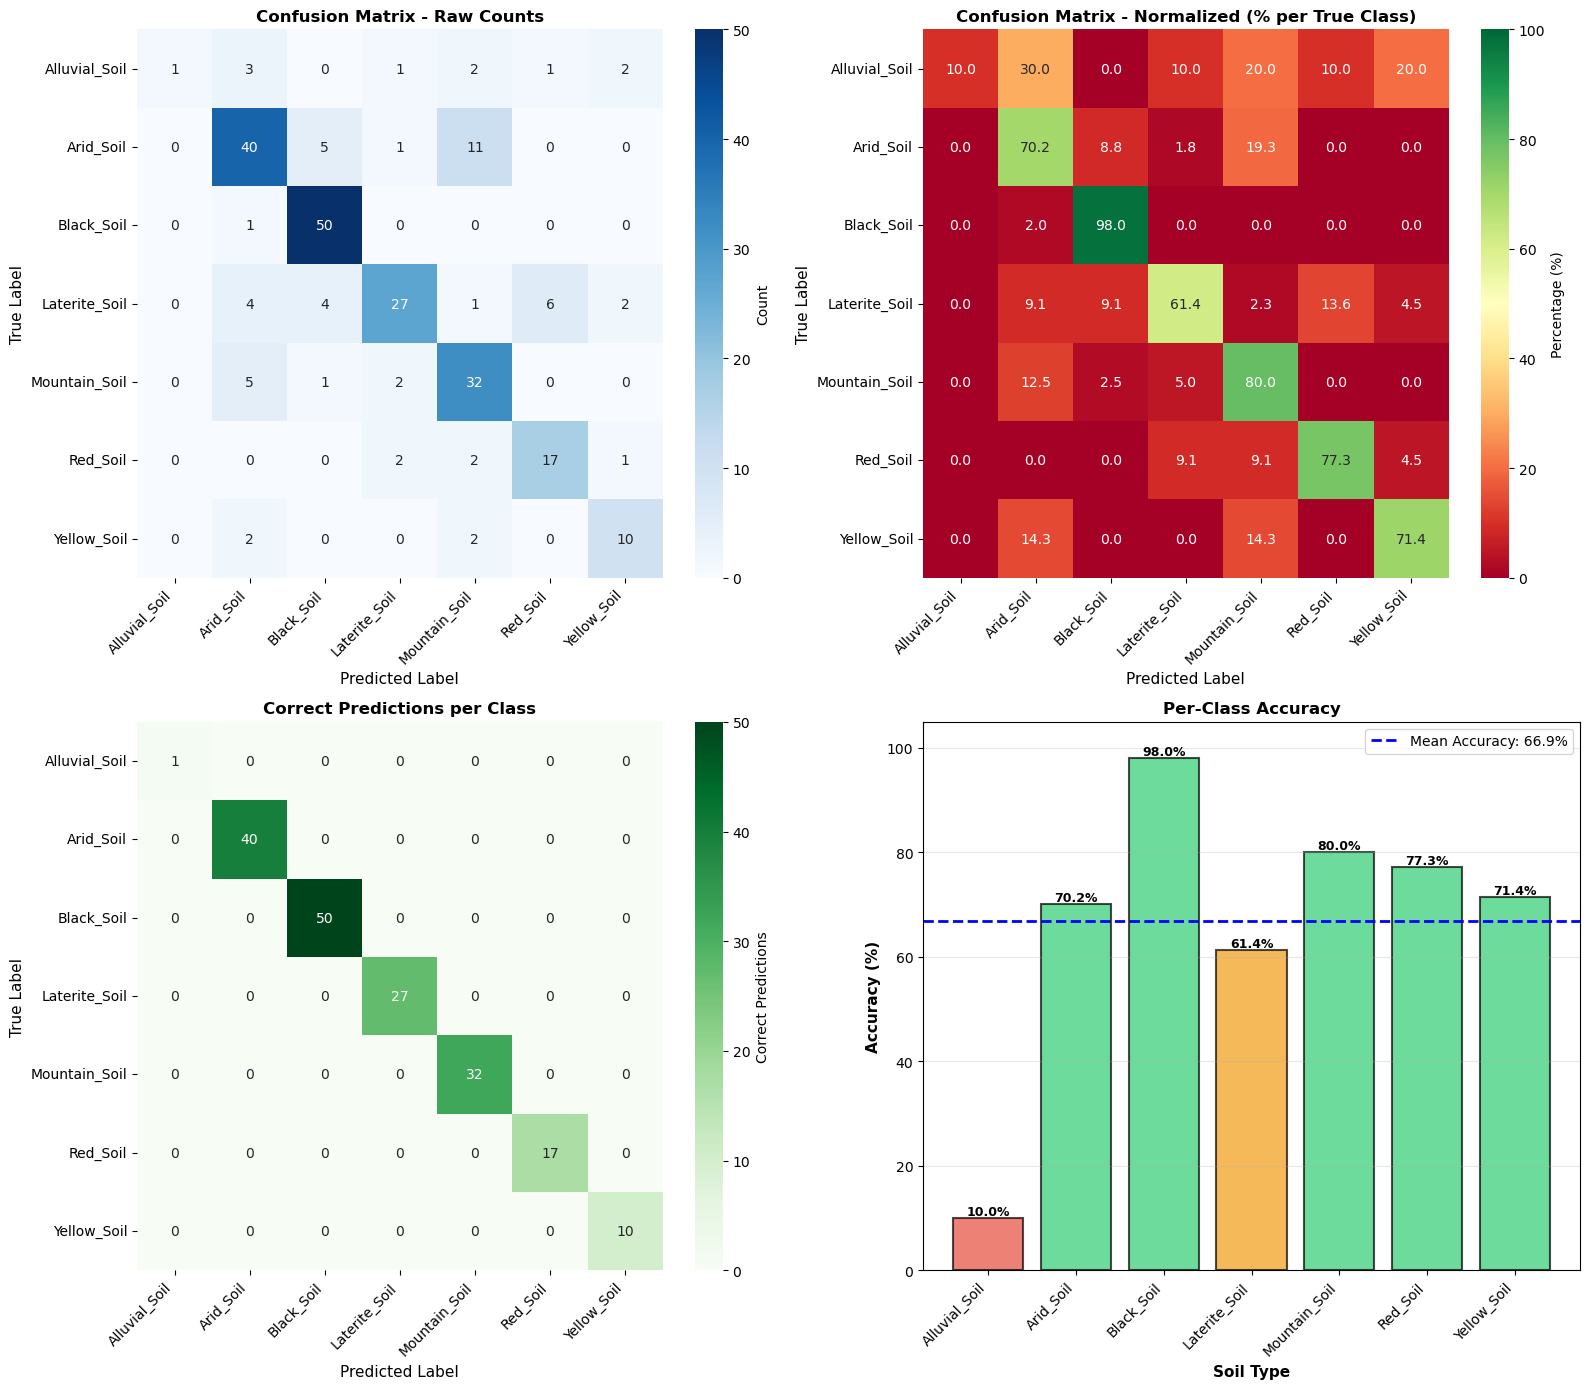


DETAILED ACCURACY ANALYSIS
Alluvial_Soil       :   1/ 10 =  10.00%
Arid_Soil           :  40/ 57 =  70.18%
Black_Soil          :  50/ 51 =  98.04%
Laterite_Soil       :  27/ 44 =  61.36%
Mountain_Soil       :  32/ 40 =  80.00%
Red_Soil            :  17/ 22 =  77.27%
Yellow_Soil         :  10/ 14 =  71.43%


In [ ]:
if 'labels' not in globals() or 'preds' not in globals():
    raise ValueError("Run the evaluation cell that defines 'labels' and 'preds' before plotting.")

cm = confusion_matrix(labels, preds, labels=list(range(len(soil_types))))

# Enhanced Confusion Matrix Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# 1. Raw Confusion Matrix (Counts)
ax = axes[0, 0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=soil_types, yticklabels=soil_types,
            cbar_kws={'label': 'Count'})
ax.set_title('Confusion Matrix - Raw Counts', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=11)
ax.set_xlabel('Predicted Label', fontsize=11)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# 2. Normalized Confusion Matrix (Percentages by True Class) - safe division
row_sums = cm.sum(axis=1, keepdims=True)
cm_normalized = np.divide(cm, row_sums, out=np.zeros_like(cm, dtype=float), where=row_sums != 0) * 100

ax = axes[0, 1]
sns.heatmap(cm_normalized, annot=True, fmt='.1f', cmap='RdYlGn', ax=ax,
            xticklabels=soil_types, yticklabels=soil_types,
            cbar_kws={'label': 'Percentage (%)'}, vmin=0, vmax=100)
ax.set_title('Confusion Matrix - Normalized (% per True Class)', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=11)
ax.set_xlabel('Predicted Label', fontsize=11)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# 3. Correct Predictions Heatmap (Diagonal Only)
cm_correct = np.zeros_like(cm, dtype=float)
for i in range(len(soil_types)):
    cm_correct[i, i] = cm[i, i]

ax = axes[1, 0]
sns.heatmap(cm_correct, annot=True, fmt='.0f', cmap='Greens', ax=ax,
            xticklabels=soil_types, yticklabels=soil_types,
            cbar_kws={'label': 'Correct Predictions'})
ax.set_title('Correct Predictions per Class', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=11)
ax.set_xlabel('Predicted Label', fontsize=11)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# 4. Per-Class Accuracy Bar Chart - safe division
class_totals = cm.sum(axis=1)
class_accuracies = np.divide(np.diag(cm), class_totals, out=np.zeros_like(class_totals, dtype=float), where=class_totals != 0) * 100

colors = ['#2ecc71' if acc >= 70 else '#f39c12' if acc >= 50 else '#e74c3c' for acc in class_accuracies]
ax = axes[1, 1]
bars = ax.bar(soil_types, class_accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

mean_acc = np.mean(class_accuracies) if len(class_accuracies) else 0.0
ax.axhline(y=mean_acc, color='blue', linestyle='--', linewidth=2, label=f'Mean Accuracy: {mean_acc:.1f}%')

ax.set_ylabel('Accuracy (%)', fontsize=11, fontweight='bold')
ax.set_xlabel('Soil Type', fontsize=11, fontweight='bold')
ax.set_title('Per-Class Accuracy', fontsize=12, fontweight='bold')
ax.set_ylim([0, 105])
ax.set_xticklabels(soil_types, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars, class_accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.1f}%',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# Print detailed accuracy summary
print("\n" + "="*70)
print("DETAILED ACCURACY ANALYSIS")
print("="*70)
for i, soil_type in enumerate(soil_types):
    correct = int(cm[i, i])
    total = int(cm[i].sum())
    accuracy = (correct / total * 100) if total > 0 else 0.0
    print(f"{soil_type:20s}: {correct:3d}/{total:3d} = {accuracy:6.2f}%")
print("="*70)

### Saving Evaluation Results

All evaluation outputs for the CNN model are saved in a dedicated results directory (main performance metrics stored in a JSON file + the confusion matrix saved as a NumPy array+ the corresponding visualization exported).  

In [ ]:
from pathlib import Path
import json
import numpy as np

print("\nSaving results to CNN folder...\n")

results_dir = (Path('..') / 'results' / 'CNN').resolve()
results_dir.mkdir(parents=True, exist_ok=True)

metrics = {
    "accuracy": float(accuracy),
    "precision": float(precision),
    "recall": float(recall),
    "f1_score": float(f1),
    "test_loss": float(test_loss)
}
metrics_path = results_dir / 'metrics.json'
with open(metrics_path, 'w', encoding='utf-8') as handle:
    json.dump(metrics, handle, indent=2)
print(f"Saved metrics to {metrics_path}")

cm_path = results_dir / 'confusion_matrix.npy'
np.save(cm_path, cm)
print(f"Saved confusion matrix array to {cm_path}")

fig_path = results_dir / 'confusion_matrix.png'
if 'fig' in globals():
    fig.savefig(fig_path, bbox_inches='tight')
    print(f"Saved confusion matrix figure to {fig_path}")
else:
    print("Figure handle 'fig' not found. Run Cell 33 before saving the figure.")


Saving results to CNN folder...

Saved metrics to C:\Users\alera\Desktop\ENTPE\Deep Learning\Project\results\CNN\metrics.json
Saved confusion matrix array to C:\Users\alera\Desktop\ENTPE\Deep Learning\Project\results\CNN\confusion_matrix.npy
Saved confusion matrix figure to C:\Users\alera\Desktop\ENTPE\Deep Learning\Project\results\CNN\confusion_matrix.png


### Hyperparameter Grid Search (CNN Optimization)

To improve the CNN performance and reduce overfitting, a grid search is applied to tune the most training hyperparameters. 

#### Parameters explored
The search tests combinations of:
- **Learning rate (`lr`)**: update step size during gradient descent.
- **Dropout rate**: for randomly disabling neurons during training.
- **Weight decay (`wd`)**: L2 regularization term applied by the optimizer to penalize large weights and improve generalization.

#### Process
For each `(lr, dropout, wd)` combination:
1. A new CNN instance is created with the selected **dropout rate**.
2. The model is trained for a fixed number of epochs using **CrossEntropyLoss** and the **Adam** optimizer.
3. After each epoch, validation loss and validation accuracy are computed.
4. The best validation accuracy achieved during training is stored as the score for this configuration.
5. If this score improves the global best score, the corresponding model weights are saved as a checkpoint.

#### Output
At the end of the search:
- a list of results is returned (one row per configuration),
- the best hyperparameter set is reported,
- the best model is reconstructed and loaded with the saved weights.

This grid search ensures that later comparisons with GAN and transformer-based approaches rely on an optimized CNN baseline rather than an arbitrary configuration.

> ```learning_rates = [1e-3, 5e-4, 1e-4]    ```  <br>
> ```dropout_options = [0.3, 0.4, 0.5]  ```    
> ```weight_decay_options = [1e-5, 1e-4]  ```

In [ ]:
import torch
import torch.nn as nn
from tqdm.auto import tqdm # Importation de tqdm

def grid_search_hyperparameters(
    train_loader,
    val_loader,
    learning_rates,
    dropout_options,
    weight_decay_options,
    device,
    epochs=10,
    model_fn=None,
    save_path="best_model.pth",
):
    assert model_fn is not None, "Fournir model_fn(dropout) -> nn.Module"

    results = []
    best_val_acc = -1.0
    best_cfg = None
    best_state = None

    # Calcul du nombre total de combinaisons pour la barre de progression
    total_combinations = len(learning_rates) * len(dropout_options) * len(weight_decay_options)
    
    # Barre de progression principale
    pbar = tqdm(total=total_combinations, desc="Grid Search Progress")

    for lr in learning_rates:
        for dropout in dropout_options:
            for wd in weight_decay_options:
                # Mise à jour du texte de la barre de progression
                pbar.set_postfix({"LR": lr, "Drop": dropout, "WD": wd})

                # Création du modèle
                model = model_fn(dropout).to(device)

                optimizer = torch.optim.Adam(
                    model.parameters(),
                    lr=lr,
                    weight_decay=wd
                )

                loss_fn = nn.CrossEntropyLoss()

                # Entraînement
                model, train_losses, val_losses, train_accs, val_accs = train_with_validation(
                    model=model,
                    train_loader=train_loader,
                    val_loader=val_loader,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    device=device,
                    epochs=epochs
                )

                cur_best_val = max(val_accs)

                results.append({
                    'lr': lr, 'dropout': dropout, 'weight_decay': wd,
                    'best_val_acc': cur_best_val,
                    'final_train_acc': train_accs[-1],
                    'final_val_acc': val_accs[-1]
                })

                if cur_best_val > best_val_acc:
                    best_val_acc = cur_best_val
                    best_cfg = {'lr': lr, 'dropout': dropout, 'weight_decay': wd}
                    best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}
                    if save_path is not None:
                        torch.save(best_state, save_path)

                # Nettoyage mémoire
                del model
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                
                # On avance la barre de 1
                pbar.update(1)

    pbar.close() # Fermeture de la barre

    # Reconstruction du meilleur modèle
    best_model = None
    if best_state is not None:
        best_model = model_fn(best_cfg['dropout']).to(device)
        best_model.load_state_dict(best_state)
        print(f"\n✅ Terminé ! Meilleure Accuracy: {best_val_acc:.4f} avec {best_cfg}")

    return results, best_cfg, best_model

# --- CONFIGURATION RECOMMANDÉE ---
learning_rates = [1e-3, 5e-4, 1e-4]      # Le "standard", le "moyen" et le "prudent"
dropout_options = [0.3, 0.4, 0.5]        # Protection progressive contre l'overfitting
weight_decay_options = [1e-5, 1e-4]      # Régularisation légère pour stabiliser les poids

# --- LANCEMENT DE LA RECHERCHE PAR GRILLE ---

# 1. Vérifie que tes loaders et ton DEVICE sont prêts
# 2. On utilise le SmartResize (target_size=128) défini plus haut
# 3. On passe la classe SimpleCNN via la lambda

results, best_cfg, best_model = grid_search_hyperparameters(
    train_loader=train_loader,      # Ton DataLoader d'entraînement
    val_loader=val_loader,          # Ton DataLoader de validation
    learning_rates=learning_rates,  # [1e-3, 5e-4, 1e-4]
    dropout_options=dropout_options,# [0.3, 0.4, 0.5]
    weight_decay_options=weight_decay_options, # [1e-5, 1e-4]
    device=DEVICE,                  # 'cuda' pour ta RTX 2060
    epochs=50,                      # 50 époques est un bon compromis pour affiner
    model_fn=lambda d: SimpleCNN(dropout_rate=d), 
    save_path="best_soil_model.pth"
)

# --- AFFICHAGE DU RÉSUMÉ ---
print("\nRésultats de la recherche :")
for res in results:
    print(f"LR: {res['lr']} | Drop: {res['dropout']} | WD: {res['weight_decay']} "
          f"-> Best Val Acc: {res['best_val_acc']:.4f}")

Grid Search Progress:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 001 | Train Loss: 1.4880 Acc: 0.440 | Val Loss: 1.4632 Acc: 0.521
Saved new best model to: C:\Users\alera\Desktop\ENTPE\Deep Learning\Project\model\best_model
Saved new best model to: C:\Users\alera\Desktop\ENTPE\Deep Learning\Project\model\best_model
Saved new best model to: C:\Users\alera\Desktop\ENTPE\Deep Learning\Project\model\best_model
